裂縫固定水平線, time-dependent heat equation

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
rc('animation', html='jshtml')

torch.set_default_dtype(torch.float64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

X_MIN, X_MAX = -1.0, 1.0
Y_MIN, Y_MAX = -1.0, 1.0
T_MIN, T_MAX = 0.0, 1.0  

N_f = 4000       
N_b_outer = 4000
N_b_crack = 2000
N_ic = 4000 # initial condition points on domain at t=0
N_ic_out = 4000  # initial condition points on domain at t=0
N_ic_crack =2000   # initial condition points on domain at t=0
epochs = 1000
lambda_bc = 1.0
lambda_ic = 1.0
lambda_zz = 1.0
lambda_zz3 = 0.0
lambda_zz2 = 0.0 # Loss weight for Uz=0 on crack

def compute_phi_and_derivs(x, y, t):
    eps = 1e-12
    x = x.view(-1, 1).to(device)
    y = y.view(-1, 1).to(device)
    t = t.view(-1, 1).to(device)
    angle = torch.tensor(np.pi * 0.0 / 4.0, dtype=x.dtype, device=x.device)
    #r = torch.sqrt(torch.clamp(x**2 + y**2, min=eps))
    r = torch.sqrt(x**2 + y**2)
    #inside = torch.clamp(r - (x * torch.cos(angle) + y * torch.sin(angle)),min=eps)
    inside = r - (x * torch.cos(angle) + y * torch.sin(angle))
    phi = torch.sqrt(0.5 * inside)
    sqrt_term = torch.sqrt(inside)
    phi_x = (torch.sqrt(torch.tensor(2.0, dtype=torch.float64)) *
             (x / r - torch.cos(angle))) / (4.0 * sqrt_term)
    phi_y = (torch.sqrt(torch.tensor(2.0, dtype=torch.float64)) *
             (y / r - torch.sin(angle))) / (4.0 * sqrt_term)
    #phi_t = (torch.sqrt(torch.tensor(2.0, dtype=torch.float64)) / 4.0 *
    #         (x * torch.sin(angle) - y * torch.cos(angle)) / sqrt_term *
    #         (np.pi**2 / 2.0) * torch.cos(2 * np.pi * t))

    return phi, phi_x, phi_y


Device: cpu


In [19]:
# MLP 
class MLP(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.net = nn.ModuleList()
        for i in range(len(layers)-1):
            self.net.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = torch.tanh
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight) #????
                nn.init.zeros_(m.bias)

    def forward(self, inp):
        z = inp
        for layer in self.net[:-1]:
            z = self.activation(layer(z))
        z = self.net[-1](z)
        return z

def partials_U_wrt_inputs(model, x, y, phi, t):
    x = x.view(-1,1)
    y = y.view(-1,1)
    phi = phi.view(-1,1)
    t = t.view(-1,1)

    inp = torch.cat([x, y, phi, t], dim=1).to(device)
    inp.requires_grad_(True)
    U = model(inp)  # (N,1)

    grads = torch.autograd.grad(U, inp, grad_outputs=torch.ones_like(U),
                                create_graph=True, retain_graph=True)[0]  # (N,4)
    U_x = grads[:,0:1]
    U_y = grads[:,1:2]
    U_z = grads[:,2:3]   
    U_t = grads[:,3:4]   
    return U, inp, U_x, U_y, U_z, U_t

def second_partials_U(model, inp, U_x, U_y, U_z):
    grad_Ux = torch.autograd.grad(U_x, inp, grad_outputs=torch.ones_like(U_x),
                                  create_graph=True, retain_graph=True)[0]
    grad_Uy = torch.autograd.grad(U_y, inp, grad_outputs=torch.ones_like(U_y),
                                  create_graph=True, retain_graph=True)[0]
    grad_Uz = torch.autograd.grad(U_z, inp, grad_outputs=torch.ones_like(U_z),
                                  create_graph=True, retain_graph=True)[0]

    U_xx = grad_Ux[:,0:1]
    U_xz = grad_Ux[:,2:3]
    U_yy = grad_Uy[:,1:2]
    U_yz = grad_Uy[:,2:3]
    U_zz = grad_Uz[:,2:3]

    return U_xx, U_yy, U_xz, U_yz, U_zz

def compute_residual_time(model, x, y, t):
    x_in = x.clone().detach().requires_grad_(True).to(device)
    y_in = y.clone().detach().requires_grad_(True).to(device)
    t_in = t.clone().detach().requires_grad_(True).to(device)

    #phi, phi_x, phi_y, phi_t = compute_phi_and_derivs(x_in, y_in, t_in)
    phi, phi_x, phi_y = compute_phi_and_derivs(x_in, y_in, t_in)
    U, inp, U_x, U_y, U_z, U_t = partials_U_wrt_inputs(model, x_in, y_in, phi, t_in)
    U_xx, U_yy, U_xz, U_yz, U_zz = second_partials_U(model, inp, U_x, U_y, U_z)

    #r = torch.sqrt(torch.clamp(x**2 + y**2, min=1e-12))
    r = torch.sqrt(x**2 + y**2)
    laplace_U = U_xx + U_yy
    lap = laplace_U + 2.0 * (U_xz * phi_x + U_yz * phi_y) + (1/(4*r)) * U_zz

    # ut =  U_t
    ut =  U_t
    residual = ut - lap - 1.0
    return residual, U, U_zz, U_xz, U_yz

# compute tip constraint 
def compute_zz_uN(model, t): # 在原點 U_xz=0, U_yz=0, U_zz=0 
    if not torch.is_tensor(t):
        t = torch.tensor([[t]], dtype=torch.float64, device=device)
    else:
        t = t.view(-1,1).to(dtype=torch.float64, device=device)

    x = torch.zeros_like(t)
    y = torch.zeros_like(t)

    phi, phi_x, phi_y = compute_phi_and_derivs(x, y, t)
    U, inp, U_x, U_y, U_z, U_t = partials_U_wrt_inputs(model, x, y, phi, t)

    grad_Uz = torch.autograd.grad(U_z, inp, grad_outputs=torch.ones_like(U_z),
                                  create_graph=True, retain_graph=True)[0]
    U_zz = grad_Uz[:,2:3]
    U_xz = grad_Uz[:,0:1]
    U_yz = grad_Uz[:,1:2]
    return torch.mean(U_zz**2 + U_xz**2 + U_yz**2)   


def compute_xyz_uN(model,x, y, t): # 在線上 U_xz=0, U_yz=0 #有此項效果不好
    if not torch.is_tensor(t):
        t = torch.tensor([[t]], dtype=torch.float64, device=device)
    else:
        t = t.view(-1,1).to(dtype=torch.float64, device=device)
    phi, phi_x, phi_y = compute_phi_and_derivs(x, y, t)
    U, inp, U_x, U_y, U_z, U_t = partials_U_wrt_inputs(model, x, y, phi, t)
    grad_Uz = torch.autograd.grad(U_z, inp, grad_outputs=torch.ones_like(U_z),
                                  create_graph=True, retain_graph=True)[0]
    U_xz = grad_Uz[:,0:1]
    U_yz = grad_Uz[:,1:2]

    return torch.mean(U_xz**2+U_yz**2)   

def compute_crack_Uz_zero(model, x, y, t): # 有此項效果不好
    phi, phi_x, phi_y = compute_phi_and_derivs(x, y, t)
    U, inp, U_x, U_y, U_z, U_t = partials_U_wrt_inputs(model, x, y, phi, t)
    return torch.mean(U_z**2)

# sampling
def sample_collocation(N): 
    x = torch.rand(N*2,1) * (X_MAX - X_MIN) + X_MIN 
    y = torch.rand(N*2,1) * (Y_MAX - Y_MIN) + Y_MIN 
    t = torch.rand(N*2,1) * (T_MAX - T_MIN) + T_MIN 
    # 點到 y=0 的距離 : |y|
    dist_to_crack = torch.abs(y)
    # mask 
    mask_crack = (dist_to_crack < 1e-8) 
    x, y, t = x[~mask_crack][:N], y[~mask_crack][:N], t[~mask_crack][:N] 
    return x.to(device), y.to(device), t.to(device)

def sample_outer_boundary(N):
    per_side = max(4, N // 4)
    xs, ys = [], []

    ys.append(torch.linspace(Y_MIN, Y_MAX, per_side).unsqueeze(1)); xs.append(torch.ones_like(ys[-1]) * X_MIN)
    ys.append(torch.linspace(Y_MIN, Y_MAX, per_side).unsqueeze(1)); xs.append(torch.ones_like(ys[-1]) * X_MAX)
    xs.append(torch.linspace(X_MIN, X_MAX, per_side).unsqueeze(1)); ys.append(torch.ones_like(xs[-1]) * Y_MIN)
    xs.append(torch.linspace(X_MIN, X_MAX, per_side).unsqueeze(1)); ys.append(torch.ones_like(xs[-1]) * Y_MAX)

    x = torch.cat(xs, dim=0)[:N]
    y = torch.cat(ys, dim=0)[:N]
    t = torch.rand(N, 1, device=device, dtype=torch.float64) * (T_MAX - T_MIN) + T_MIN

    return x.to(device), y.to(device), t


def sample_crack_boundary(N):
    t = torch.rand(N, 1, device=device, dtype=torch.float64) * (T_MAX - T_MIN) + T_MIN
    x_vals = torch.linspace(0, 1, N, device=device, dtype=torch.float64).unsqueeze(1)
    y_vals = x_vals * 0.0  
    return x_vals, y_vals, t

# model (input: x,y,phi,t) 
layers = [4, 64, 64, 1]
model = MLP(layers).to(device)    

In [ ]:
# training points 
x_f, y_f, t_f = sample_collocation(N_f)
x_b_out, y_b_out, t_b_out = sample_outer_boundary(N_b_outer)
x_b_crack, y_b_crack, t_b_crack = sample_crack_boundary(N_b_crack)
# move tensors to device
x_b_out = x_b_out.to(device); y_b_out = y_b_out.to(device); t_b_out = t_b_out.to(device)
x_b_crack = x_b_crack.to(device); y_b_crack = y_b_crack.to(device); t_b_crack = t_b_crack.to(device)
# cat
x_b = torch.cat([x_b_out, x_b_crack])
y_b = torch.cat([y_b_out, y_b_crack])
t_b = torch.cat([t_b_out, t_b_crack])
#
phi_b, _, _= compute_phi_and_derivs(x_b, y_b, t_b)
inp_bc = torch.cat([x_b, y_b, phi_b, t_b], dim=1)
# g=0 on boundary
g_b = torch.zeros_like(x_b, device=device)

# initial condition t=0: u(x,y,0)=0
x_ic_f, y_ic_f = sample_collocation(N_ic)[0:2] 
x_ic_out, y_ic_out = sample_outer_boundary(N_ic_out)[0:2]  
#x_ic_crack, y_ic_crack = sample_crack_boundary(N_ic_crack)[0:2]
x_ic_f = x_ic_f.view(-1,1)  
x_ic_out = x_ic_out.view(-1,1)  
#x_ic_crack = x_ic_crack.view(-1,1)
#x_ic = torch.cat([x_ic_f, x_ic_out, x_ic_crack])
x_ic = torch.cat([x_ic_f, x_ic_out])
y_ic_f = y_ic_f.view(-1,1)  
y_ic_out = y_ic_out.view(-1,1)  
#y_ic_crack = y_ic_crack.view(-1,1)
#y_ic = torch.cat([y_ic_f, y_ic_out, y_ic_crack])
y_ic = torch.cat([y_ic_f, y_ic_out])
t_ic = torch.zeros_like(x_ic).to(device)
u0 = torch.zeros_like(x_ic).to(device)
## 把四個角落的點加入訓練data中
corners = torch.tensor([
    [-1.0, -1.0],
    [-1.0,  1.0],
    [ 1.0, -1.0],
    [ 1.0,  1.0],
], dtype=torch.float64, device=device)

x_ic = torch.cat([x_ic, corners[:,0:1]], dim=0)
y_ic = torch.cat([y_ic, corners[:,1:1+1]], dim=0)
t_ic = torch.cat([t_ic, torch.zeros((4,1), dtype=torch.float64, device=device)], dim=0)
u0   = torch.cat([u0,   torch.zeros((4,1), dtype=torch.float64, device=device)], dim=0)
##
phi_ic, _, _ = compute_phi_and_derivs(x_ic, y_ic, t_ic)
inp_ic = torch.cat([x_ic, y_ic, phi_ic, t_ic], dim=1)
## 角落loss另外算用
x_ic_corners = corners[:, 0:1]     # shape (4,1)
y_ic_corners = corners[:, 1:2]     # shape (4,1)
t_ic_corners = torch.zeros((4,1), dtype=torch.float64, device=device)
u0_corners   = torch.zeros((4,1), dtype=torch.float64, device=device)
phi_ic_corners, _, _ = compute_phi_and_derivs(x_ic_corners, y_ic_corners, t_ic_corners)
inp_ic_corners = torch.cat([x_ic_corners, y_ic_corners, phi_ic_corners, t_ic_corners],dim=1)
##
# validation
x_f_val, y_f_val, t_f_val = sample_collocation(500)
x_b_out_val, y_b_out_val, t_b_out_val = sample_outer_boundary(200)
x_b_crack_val, y_b_crack_val, t_b_crack_val = sample_crack_boundary(100)
x_f_val = x_f_val.view(-1,1)  
x_b_out_val = x_b_out_val.view(-1,1)  
x_b_crack_val = x_b_crack_val.view(-1,1)
#x_b_val = torch.cat([x_f_val, x_b_out_val, x_b_crack_val])
x_b_val = torch.cat([x_b_out_val, x_b_crack_val])
y_f_val = y_f_val.view(-1,1)  
y_b_out_val = y_b_out_val.view(-1,1)  
y_b_crack_val = y_b_crack_val.view(-1,1)
#y_b_val = torch.cat([y_f_val, y_b_out_val, y_b_crack_val])
y_b_val = torch.cat([y_b_out_val, y_b_crack_val])
t_f_val = t_f_val.view(-1,1)  
t_b_out_val = t_b_out_val.view(-1,1)  
t_b_crack_val = t_b_crack_val.view(-1,1)
#t_b_val = torch.cat([t_f_val, t_b_out_val, t_b_crack_val])
t_b_val = torch.cat([t_b_out_val, t_b_crack_val])
phi_b_val, _, _ = compute_phi_and_derivs(x_b_val, y_b_val, t_b_val)
inp_bc_val = torch.cat([x_b_val, y_b_val, phi_b_val, t_b_val], dim=1)
g_b_val = torch.zeros_like(x_b_val, device=device)
###
x_ic_f_val, y_ic_f_val = sample_collocation(500)[0:2] 
x_ic_out_val, y_ic_out_val = sample_outer_boundary(200)[0:2]  
x_ic_f_val = x_ic_f_val.view(-1,1)  
x_ic_out_val = x_ic_out_val.view(-1,1)  
x_ic_val = torch.cat([x_ic_f_val, x_ic_out_val])
y_ic_f_val = y_ic_f_val.view(-1,1)  
y_ic_out_val = y_ic_out_val.view(-1,1)  
y_ic_val = torch.cat([y_ic_f_val, y_ic_out_val])
t_ic_val = torch.zeros_like(x_ic_val).to(device)
u0_val = torch.zeros_like(x_ic_val).to(device)
## 把四個角落的點加入val data中
x_ic_val = torch.cat([x_ic_val, corners[:,0:1]], dim=0)
y_ic_val = torch.cat([y_ic_val, corners[:,1:1+1]], dim=0)
t_ic_val = torch.cat([t_ic_val, torch.zeros((4,1), dtype=torch.float64, device=device)], dim=0)
u0_val   = torch.cat([u0_val,   torch.zeros((4,1), dtype=torch.float64, device=device)], dim=0)
phi_ic_val, _, _ = compute_phi_and_derivs(x_ic_val, y_ic_val, t_ic_val)
inp_ic_val = torch.cat([x_ic_val, y_ic_val, phi_ic_val, t_ic_val], dim=1)
## 角落loss另外算用
x_ic_corners_val = corners[:, 0:1]     # shape (4,1)
y_ic_corners_val = corners[:, 1:2]     # shape (4,1)
t_ic_corners_val = torch.zeros((4,1), dtype=torch.float64, device=device)
u0_corners_val   = torch.zeros((4,1), dtype=torch.float64, device=device)
phi_ic_corners_val, _, _ = compute_phi_and_derivs(x_ic_corners_val, y_ic_corners_val, t_ic_corners_val)
inp_ic_corners_val = torch.cat([x_ic_corners_val, y_ic_corners_val, phi_ic_corners_val, t_ic_corners_val],dim=1)
###
# optimizer
optimizer = optim.LBFGS(model.parameters(), lr=1.0, max_iter=20, history_size=50, line_search_fn="strong_wolfe")

print("Start training (time-dependent PINN)")

loss_history = []
val_history = []

for ep in range(epochs):
    def closure():
        optimizer.zero_grad()
        residual_f, _, Uzz_f, Uxz_f, Uyz_f = compute_residual_time(model, x_f, y_f, t_f)
        loss_pde = torch.mean(residual_f**2)
        u_bc = model(inp_bc)
        loss_bc = torch.mean((u_bc - g_b)**2)
        u_ic_pred = model(inp_ic)
        u_pred_corners = model(inp_ic_corners)
        loss_ic = torch.mean((u_ic_pred - u0)**2)
        loss_zz = compute_zz_uN(model, t_b_crack)
        loss_yxz = compute_xyz_uN(model, x_b_crack, y_b_crack, t_b_crack)
        loss_Uz_crack = compute_crack_Uz_zero(model, x_b_crack, y_b_crack, t_b_crack)
        loss_ic_corners = torch.mean((u_pred_corners - u0_corners)**2)
        loss = (loss_pde
        + lambda_bc * (loss_bc)
        + lambda_ic * loss_ic
        + lambda_zz * loss_zz
        + lambda_zz3 * loss_yxz
        + lambda_ic * loss_ic_corners
        + lambda_zz2 * loss_Uz_crack)
        loss.backward()
        return loss

    loss = optimizer.step(closure)
    loss_history.append(loss.item())
        # resampling 
    if ep % 50 == 0 and ep > 0:
        print(f"\n[Resample] epoch {ep}: regenerating PDE/BC/IC points...\n")

        # PDE collocation
        x_f, y_f, t_f = sample_collocation(N_f)

        # Outer boundary
        x_b_out, y_b_out, t_b_out = sample_outer_boundary(N_b_outer)

        # Crack boundary
        x_b_crack, y_b_crack, t_b_crack = sample_crack_boundary(N_b_crack)

        # Combine BC
        x_b = torch.cat([x_b_out, x_b_crack])
        y_b = torch.cat([y_b_out, y_b_crack])
        t_b = torch.cat([t_b_out, t_b_crack])
        phi_b, _, _ = compute_phi_and_derivs(x_b, y_b, t_b)
        inp_bc = torch.cat([x_b, y_b, phi_b, t_b], dim=1)
        g_b = torch.zeros_like(x_b, device=device)

        # Initial condition t=0
        x_ic_f, y_ic_f = sample_collocation(N_ic)[0:2]
        x_ic_out, y_ic_out = sample_outer_boundary(N_ic_out)[0:2]
        #x_ic_crack, y_ic_crack = sample_crack_boundary(N_ic_crack)[0:2]

        x_ic = torch.cat([
            x_ic_f.view(-1,1),
            x_ic_out.view(-1,1),
            #x_ic_crack.view(-1,1)
        ])
        y_ic = torch.cat([
            y_ic_f.view(-1,1),
            y_ic_out.view(-1,1),
            #y_ic_crack.view(-1,1)
        ])
        t_ic = torch.zeros_like(x_ic)
        u0 = torch.zeros_like(x_ic)
        ## 把四個角落的點加入訓練data中
        corners = torch.tensor([
        [-1.0, -1.0],
        [-1.0,  1.0],
        [ 1.0, -1.0],
        [ 1.0,  1.0],
        ], dtype=torch.float64, device=device)

        x_ic = torch.cat([x_ic, corners[:,0:1]], dim=0)
        y_ic = torch.cat([y_ic, corners[:,1:1+1]], dim=0)
        t_ic = torch.cat([t_ic, torch.zeros((4,1), dtype=torch.float64, device=device)], dim=0)
        u0   = torch.cat([u0,   torch.zeros((4,1), dtype=torch.float64, device=device)], dim=0)
        ##
        phi_ic, _, _ = compute_phi_and_derivs(x_ic, y_ic, t_ic)
        inp_ic = torch.cat([x_ic, y_ic, phi_ic, t_ic], dim=1)


    if ep % 10 == 0 or ep == epochs-1:

        # validation
        res_val, _, Uzz_val, Uxz_val, Uyz_val = compute_residual_time(model, x_f_val, y_f_val, t_f_val)
        loss_pde_val = torch.mean(res_val**2)
        u_bc_val = model(inp_bc_val)
        loss_bc_val = torch.mean((u_bc_val - g_b_val)**2)
        u_ic_pred_val = model(inp_ic_val)
        loss_ic_val = torch.mean((u_ic_pred_val - u0_val)**2)
        loss_zz_val = compute_zz_uN(model, t_b_crack_val)
        loss_yxz_val = compute_xyz_uN(model, x_b_crack_val, y_b_crack_val,  t_b_crack_val)
        loss_Uz_crack_val = compute_crack_Uz_zero(model, x_b_crack_val, y_b_crack_val, t_b_crack_val)
        u_pred_corners_val = model(inp_ic_corners_val)
        loss_ic_corners_val = torch.mean((u_pred_corners_val - u0_corners_val)**2)
        loss_val = (
            loss_pde_val
            + lambda_bc * loss_bc_val
            + lambda_ic * loss_ic_val
            + lambda_ic * loss_ic_corners_val
            + lambda_zz * loss_zz_val
            + lambda_zz3 *  loss_yxz_val
            + lambda_zz2 * loss_Uz_crack_val)
        val_history.append(loss_val.item())

        # training loss 細項
        res_f, _, _, _, _ = compute_residual_time(model, x_f, y_f, t_f)
        loss_pde = torch.mean(res_f**2)
        loss_bc = torch.mean((model(inp_bc) - g_b)**2)
        loss_ic = torch.mean((model(inp_ic) - u0)**2)
        loss_zz = compute_zz_uN(model, t_b_crack)
        loss_yxz = compute_xyz_uN(model, x_b_crack, y_b_crack, t_b_crack)
        loss_ic_corners = torch.mean((model(inp_ic_corners) - u0_corners)**2)
        loss_Uz_crack = compute_crack_Uz_zero(model, x_b_crack, y_b_crack, t_b_crack)

        # 
        print(
            f"Epoch {ep:4d} | "
            f"TrainLoss={loss.item():.3e} "
            f"(pde={loss_pde:.2e}, bc={loss_bc:.2e}, ic={loss_ic:.2e}, "
            f"zz={loss_zz:.2e}, yxz={loss_yxz:.2e}, cn={loss_ic_corners:.2e}) | "
            f"ValLoss={loss_val.item():.3e} "
            f"(pde={loss_pde_val:.2e}, bc={loss_bc_val:.2e}, ic={loss_ic_val:.2e}, "
            f"zz={loss_zz_val:.2e}, yxz={loss_yxz_val:.2e}, cn={loss_ic_corners_val:.2e})")



print("Training finished.")



Start training (time-dependent PINN)
Epoch    0 | TrainLoss=1.703e+00 (pde=1.87e-02, bc=1.52e-02, ic=2.66e-03, zz=9.76e-04, yxz=7.86e-03, cn=5.11e-03) | ValLoss=4.209e-02 (pde=1.92e-02, bc=1.41e-02, ic=2.74e-03, zz=9.62e-04, yxz=7.95e-03, cn=5.11e-03)
Epoch   10 | TrainLoss=2.627e-03 (pde=6.03e-04, bc=1.12e-03, ic=5.78e-04, zz=4.47e-05, yxz=1.44e-03, cn=7.82e-05) | ValLoss=2.653e-03 (pde=6.16e-04, bc=1.26e-03, ic=6.59e-04, zz=3.59e-05, yxz=1.47e-03, cn=7.82e-05)
Epoch   20 | TrainLoss=1.334e-03 (pde=1.43e-04, bc=5.64e-04, ic=5.74e-04, zz=1.06e-05, yxz=2.98e-04, cn=3.28e-06) | ValLoss=1.365e-03 (pde=1.49e-04, bc=6.28e-04, ic=5.75e-04, zz=9.76e-06, yxz=2.52e-04, cn=3.28e-06)
Epoch   30 | TrainLoss=9.882e-04 (pde=1.36e-04, bc=3.78e-04, ic=4.36e-04, zz=3.91e-06, yxz=4.11e-04, cn=4.03e-06) | ValLoss=1.008e-03 (pde=1.53e-04, bc=4.05e-04, ic=4.43e-04, zz=3.54e-06, yxz=3.91e-04, cn=4.03e-06)
Epoch   40 | TrainLoss=7.542e-04 (pde=1.24e-04, bc=3.17e-04, ic=2.87e-04, zz=1.32e-05, yxz=1.85e-04, cn

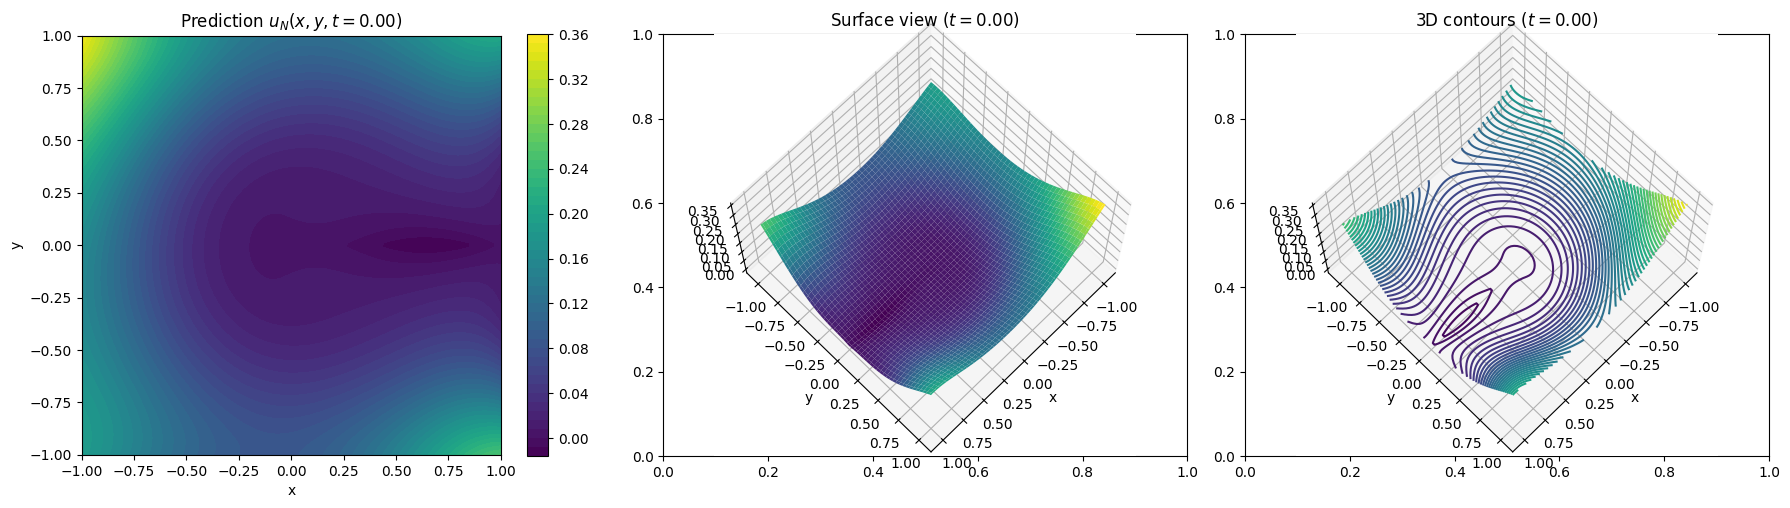

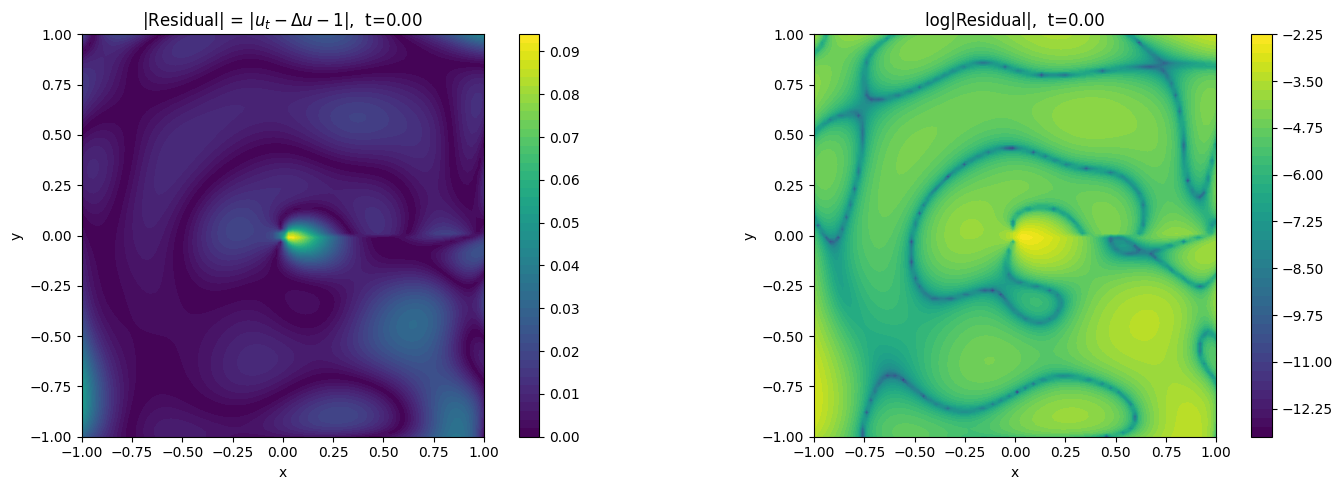

In [21]:
# test 
t0 = 0.0
nx = 100
xs = np.linspace(X_MIN, X_MAX, nx)
ys = np.linspace(Y_MIN, Y_MAX, nx)
Xg, Yg = np.meshgrid(xs, ys)

x_grid = torch.from_numpy(Xg.flatten()[:,None]).to(device).double()
y_grid = torch.from_numpy(Yg.flatten()[:,None]).to(device).double()
t_grid = torch.full_like(x_grid, t0).to(device)  # 全部時間都固定為 t0

def compute_phi(x, y, t):
    x = x.view(-1,1).to(device)
    y = y.view(-1,1).to(device)
    t = t.view(-1,1).to(device)
    angle = torch.tensor(np.pi * 0.0 / 4.0, dtype=x.dtype, device=x.device)
    r = torch.sqrt(x**2 + y**2)
    inside = r - (x * torch.cos(angle) + y * torch.sin(angle))
    return torch.sqrt(inside)


with torch.no_grad():
    phi_grid = compute_phi(x_grid, y_grid, t_grid)


# 預測 u
with torch.no_grad():
    inp_grid = torch.cat([x_grid, y_grid, phi_grid, t_grid], dim=1)
    u_pred = model(inp_grid)
    U_pred = u_pred.cpu().numpy().reshape(nx, nx)

#print(u_pred[0])  # 左下角
#print(u_pred[99])  # 右上角
#idx = np.argmax(u_pred)      # 最大值的一維 index
#val = u_pred[idx]            # 最大值
#print(idx, val)

fig, axs = plt.subplots(1, 3, figsize=(18,5))

im0 = axs[0].contourf(Xg, Yg, U_pred, 50, cmap='viridis')
fig.colorbar(im0, ax=axs[0])
axs[0].set_title(f'Prediction $u_N(x,y,t={t0:.2f})$')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_aspect('equal')


ax1 = fig.add_subplot(132, projection='3d')
ax1.plot_surface(Xg, Yg, U_pred, cmap='viridis', edgecolor='none')
ax1.set_title(f'Surface view ($t={t0:.2f}$)')
ax1.set_xlabel('x'); ax1.set_ylabel('y')
ax1.view_init(elev=70, azim=45)

ax2 = fig.add_subplot(133, projection='3d')
ax2.contour3D(Xg, Yg, U_pred, 50, cmap='viridis')
ax2.set_title(f'3D contours ($t={t0:.2f}$)')
ax2.set_xlabel('x'); ax2.set_ylabel('y')
ax2.view_init(elev=70, azim=45)

plt.tight_layout()
plt.show()

# 殘差圖 
res, _, _, _, _ = compute_residual_time(model, x_grid, y_grid, t_grid)
abs_residual = torch.abs(res).detach().cpu().numpy().reshape(nx, nx)
log_abs_residual = np.log(abs_residual + 1e-12)  


fig, axs = plt.subplots(1, 2, figsize=(15,5))
im0 = axs[0].contourf(Xg, Yg, abs_residual, 50, cmap='viridis')
fig.colorbar(im0, ax=axs[0])
axs[0].set_title(f'|Residual| = |$u_t - \\Delta u - 1$|,  t={t0:.2f}')
axs[0].set_xlabel('x'); axs[0].set_ylabel('y'); axs[0].set_aspect('equal')

im1 = axs[1].contourf(Xg, Yg, log_abs_residual, 50, cmap='viridis')
fig.colorbar(im1, ax=axs[1])
axs[1].set_title(f'log|Residual|,  t={t0:.2f}')
axs[1].set_xlabel('x'); axs[1].set_ylabel('y'); axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()


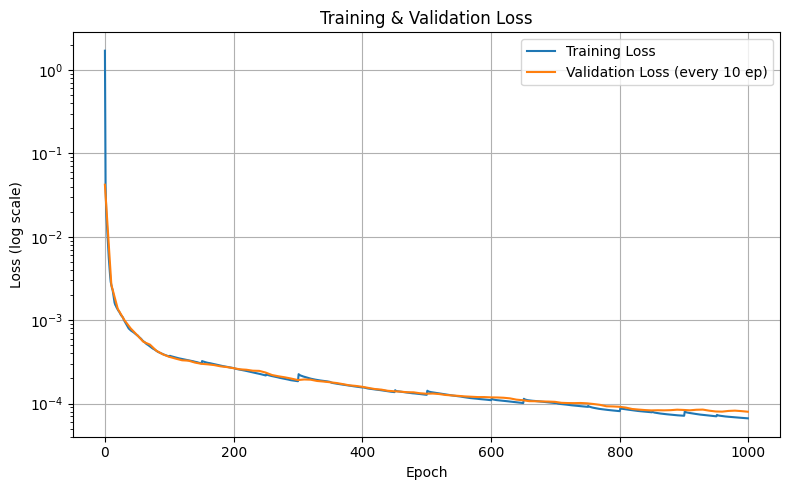

In [22]:
# loss 
epochs_arr = np.arange(len(loss_history))
val_epochs = np.linspace(0, len(loss_history)-1, len(val_history))
plt.figure(figsize=(8,5))
plt.semilogy(epochs_arr, loss_history, label='Training Loss')
plt.semilogy(val_epochs, val_history, label='Validation Loss (every 10 ep)')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


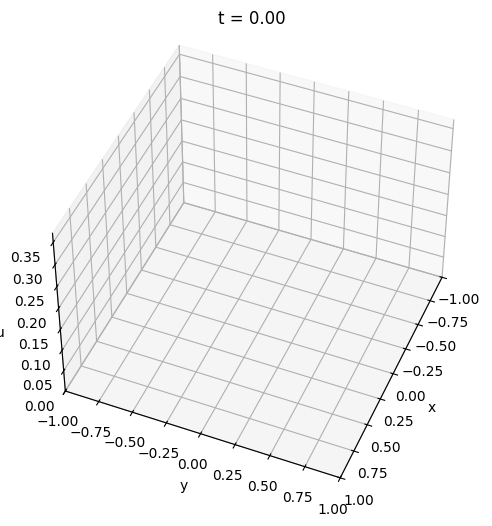

In [ ]:
from matplotlib import animation

# ===== animation settings =====
t_start = 0.0
t_end = 1.0
num_frames = 60
t_values = np.linspace(t_start, t_end, num_frames)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

def init():
    ax.clear()
    ax.set_xlim(X_MIN, X_MAX)
    ax.set_ylim(Y_MIN, Y_MAX)
    ax.set_zlim(0, 0.37)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("u")
    ax.set_title("t = 0.00")
    return []

def update(frame_idx):
    ax.clear()

    ax.set_xlim(X_MIN, X_MAX)
    ax.set_ylim(Y_MIN, Y_MAX)
    ax.set_zlim(0, 0.37)

    t0 = t_values[frame_idx]
    t_grid = torch.full_like(x_grid, t0).to(device)

    with torch.no_grad():
        phi_grid = compute_phi(x_grid, y_grid, t_grid)
        inp_grid = torch.cat([x_grid, y_grid, phi_grid, t_grid], dim=1)
        u_pred = model(inp_grid)
        U = u_pred.cpu().numpy().reshape(nx, nx)

    surf = ax.plot_surface(Xg, Yg, U, cmap='viridis', edgecolor='none')

    ax.view_init(elev=45, azim=22.5)
    ax.set_title(f"u_N(x,y,t={t0:.2f})")

    # <<<< 必須回傳 artist，不可以 return [] >>>>
    return [surf]

ani = animation.FuncAnimation(
    fig, update, frames=num_frames, init_func=init, blit=False
)

# ====== 儲存動畫 ======
#from matplotlib.animation import PillowWriter
#writer = PillowWriter(fps=20)
#ani.save("u_surface_animation.gif", writer=writer)
